In [1]:
import numpy as np

In [205]:
class antonForest():

    def __init__(self, t_trees, sample_size, random_state) -> None:
        self.t_trees = t_trees
        self.sample_size = sample_size
        self.random_state = random_state

    def fit(self, X):
        
        self.forest = []
        height_limit = np.ceil(np.log2(self.sample_size))
        n_rows = X.shape[0]
        if n_rows < self.sample_size:
            self.sample_size = n_rows
        for i in range(self.t_trees):
            
            #if n_rows < self.sample_size:
             #   self.sample_size = n_rows
            #index = self.random_state.choice(range(n_rows), size = self.sample_size, replace = False)
            #This row makes the subsampling and split values random for each run
            index = self.random_state.randint(0, n_rows, self.sample_size)
            #index = np.random.choice(range(n_rows), size=self.sample_size, replace=False)
            #index = np.random.randint(0, n_rows, self.sample_size)
            
            sub_X = X[index]
            
            tree = iTree(0, height_limit)
            tree.fit(sub_X)
            self.forest.append(tree)
            
        return self

    def path_length(self, data):

        edges = []

        for row in data:
            path = []
            for tree in self.forest:
                node = tree.root
                length = 0
                while isinstance(node, DecisionNode):
                    if row[node.q_value] < node.x_value:
                        node = node.left
                    else:
                        node = node.right
                    length += 1
                leaf_size = node.size
                path_length = length + c(leaf_size)
                path.append(path_length)
            
            edges.append(path)
        edges = np.array(edges)
        return np.mean(edges, axis = -1)

    def decision_function(self, data):

        average_length = self.path_length(data)
        scores = np.array([np.power(2, -l/c(self.sample_size)) for l in average_length])
        #WARNING fix - and +0.5
        scores = -scores +0.5250543855355995 #-0.4209613673797462  
        return scores

    def predict_from_score(self, scores, threshold):
        return np.array([1 if s >= threshold else 0 for s in scores])

    def predict(self, data, threshold):
        scores = self.decision_function(data)
        prediction = self.predict_from_score(scores, threshold)
        return prediction

In [206]:
class Leaf:

    def __init__(self, size, data) -> None:
        self.size = size
        self.data = data

In [207]:
class DecisionNode:

    def __init__(self, left, right, q_value, x_value) -> None:
        self.left = left
        self.right = right
        self.q_value = q_value
        self.x_value = x_value

In [208]:
class iTree():

    def __init__(self, current_height, height_limit) -> None:
        self.current_height = current_height
        self.heigh_limit = height_limit

    def fit(self, sub_sample):
        
        X = sub_sample
        
        if self.current_height >= self.heigh_limit or X.shape[0] <= 2:
            self.root = Leaf(X.shape[0], X)
            return self.root
        else:
            #Chosing random q value
            n_attributes = X.shape[1]#WARNING changed from 1 to 0
            q_value = np.random.randint(0, n_attributes)
            #Chosing random x value
            x_value = np.random.uniform(min(X[:, q_value]), max(X[:, q_value]))

            X_left = X[X[:, q_value] < x_value]
            X_right = X[X[:, q_value] >= x_value]

            left_subtree = iTree(self.current_height + 1, self.heigh_limit)
            right_subtree = iTree(self.current_height + 1, self.heigh_limit)

            left_subtree.fit(X_left)
            right_subtree.fit(X_right)

            self.root = DecisionNode(left_subtree.root, right_subtree.root, q_value, x_value)
            self.n_nodes = self.count_nodes(self.root)

            return self.root

    def count_nodes(self, root):
            
        count = 0
        stack = [root]
           
        while stack:
            node = stack.pop()
            count += 1

        if isinstance(node, DecisionNode):
            stack.append(node.right)
            stack.append(node.left)

        return count


Code for testing and running the classes and functions:

In [209]:
from __future__ import division
from __future__ import print_function
from sklearn.ensemble import IsolationForest

import os
import sys
from time import time

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from numpy import percentile
from sklearn.metrics import average_precision_score
import scipy.io
import matplotlib.pyplot as plt

In [210]:
# Define the number of inliers and outliers
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

In [211]:
random_state = np.random.RandomState(42)

In [212]:
# Fit the models with the generated data and 
# compare model performances
def c(size):
    if size > 2:
        return 2 * (np.log(size-1)+0.5772156649) - 2*(size-1)/size
    if size == 2:
        return 1
    return 0

np.random.seed(42)
clf = antonForest(100, 256, random_state=random_state)
clf_lib = IsolationForest(n_estimators = 100, random_state=random_state)
# Data generation
#X1 = 0.3 * np.random.randn(n_inliers // 2, 2) #Removed offest
#X2 = 0.3 * np.random.randn(n_inliers // 2, 2) #Removed offset
#X = np.r_[X1, X2]
# Add outliers
#X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

data = scipy.io.loadmat('C:\\Users\\anton\\OneDrive\\Skrivbord\\Thesis_Code\\IsolationForestTinyML\\DatSets\\ionosphere.mat',
                        squeeze_me=False)

enlist = list(data.items())
X = np.array(enlist, dtype=object)
X = np.delete(X, 0, 0)
X = np.delete(X, 0, 0)
X = np.delete(X, 0, 0)
X = np.delete(X, 0, 1)

y_true = np.empty([1,0], dtype=int)

#print(X[1][0][0])
k = 0
#while k < len(X[1][0]):
#    y_true = np.append(y_true, int(X[1][0][k]))
#    k += 1

X = X[0][0]
#print(X[0][0])
# Fit the model
#plt.figure(figsize=(15, 12))
# fit the data and tag outliers
p = 0
aps = []
aps_lib = []
outliers = 10
#while p < 10:
clf.fit(X)
clf_lib.fit(X)
#WARNING put +1
scores_pred = clf.decision_function(X) * 1

scores_pred_lib = clf_lib.decision_function(X) * 1 

threshold = percentile(scores_pred, 100 * outliers_fraction)
threshold_lib = percentile(scores_pred_lib, 100 * outliers_fraction)


#aps.append(average_precision_score(y_true, scores_pred))
#aps_lib.append(average_precision_score(y_true, scores_pred_lib))
#p += 1
#n_errors = (y_pred != ground_truth).sum()
# plot the levels lines and the points

#WARNING +1
#Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * 1
#Z = Z.reshape(xx.shape)
#plt.figure(figsize=[10,10])
#subplot = plt.subplot(2, 2, 1)
#subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
#                    cmap=plt.cm.Blues_r)
#a = subplot.contour(xx, yy, Z, levels=[threshold], #Removed - in front of threshold, since -score
#                    linewidths=2, colors='red')
#subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
#                    colors='orange')
#b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
#                    s=20, edgecolor='k')
#c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
#                    s=20, edgecolor='k')
#subplot.axis('tight')
#subplot.set_xlabel("%d. %s (errors: %d)" % (1, "Isolation Forest", n_errors))
#subplot.set_xlim((-7, 7))
#subplot.set_ylim((-7, 7))
#plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
#plt.suptitle("Outlier detection")
#plt.show()
#all_data = [aps, aps_lib]
#plt.boxplot(all_data)
#print(scores_pred)
#print(scores_pred_lib)

In [213]:
print(X.shape[0])

129


In [214]:
#print(scores_pred)
print(scores_pred)


[ 0.02075153  0.00284255  0.04231563 -0.00718582  0.00053502  0.02556823
 -0.0181624   0.06419649 -0.02390923  0.0104382  -0.01732614  0.01794773
  0.04686444  0.07210969  0.03495047  0.06537445  0.08315043 -0.00453954
  0.07053864  0.02777402 -0.03458843  0.05816111 -0.00360821  0.08444923
 -0.0659752   0.03136581  0.04898021  0.03399813  0.07945705 -0.02563332
  0.04175103  0.05087406  0.07932245  0.04884129  0.07111325  0.06789617
  0.09821856  0.0873528   0.0420963   0.09351104  0.05231229  0.09849703
  0.08915145  0.07895342  0.06380698  0.03938898 -0.01391923  0.01197329
  0.06211439  0.03312929  0.00828234  0.05144751  0.08486793  0.08942498
  0.08796208  0.08123925  0.0716394   0.09009615  0.10960586  0.07081779
  0.03630415 -0.01115661  0.07914238  0.02982442  0.08529903  0.0888416
  0.00175004  0.08571747  0.09307087  0.03199268  0.06636945  0.06111437
 -0.07169677  0.01205423  0.00781205 -0.0153832   0.09024108  0.0568527
  0.04111154  0.0734671   0.06565764  0.03943286  0.0

In [215]:
#print(scores_pred_lib)
print(scores_pred_lib)

[ 0.01669184  0.00515473  0.05146643 -0.00547119 -0.00059348  0.03095742
 -0.00998812  0.05942021 -0.0349231  -0.00316742 -0.06395142  0.00918045
  0.05393689  0.0488285   0.04397609  0.04639708  0.07040348  0.00169034
  0.05296525  0.02083627 -0.0419589   0.03803893 -0.00221261  0.07508383
 -0.08267784  0.01710875  0.04180126  0.02780292  0.08832095  0.00675496
  0.04010822  0.03191191  0.09342941  0.05323876  0.08005986  0.05904484
  0.09137652  0.08382863  0.03752688  0.09494368  0.06112219  0.08445183
  0.07995298  0.08538066  0.05444135  0.05153005 -0.03015201  0.03459267
  0.08058774  0.02515008 -0.00078449  0.06544617  0.08105317  0.08829696
  0.08673784  0.08947275  0.02256765  0.0871629   0.0933216   0.06147927
  0.0580874  -0.03798971  0.07936059  0.03764077  0.06209469  0.07232379
  0.00376812  0.08115689  0.07910372  0.03761152  0.06531724  0.05629769
 -0.1236495   0.00887783 -0.0017858  -0.02653565  0.09099972  0.06039556
  0.02672626  0.06625448  0.0724465   0.05260476  0

In [216]:
diff = scores_pred - scores_pred_lib
print(np.mean(diff))

-4.3031900179269636e-17


(array([ 2.,  1.,  6.,  8., 12., 17., 26., 30., 22.,  5.]),
 array([-0.07169677, -0.05356651, -0.03543625, -0.01730598,  0.00082428,
         0.01895454,  0.0370848 ,  0.05521507,  0.07334533,  0.09147559,
         0.10960586]),
 <BarContainer object of 10 artists>)

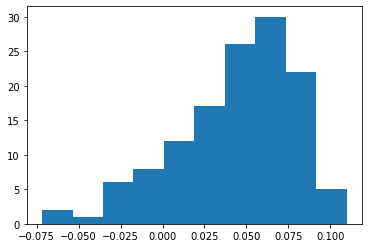

In [217]:
plt.hist(scores_pred)

(array([ 1.,  1.,  2.,  2.,  4., 12., 18., 17., 37., 35.]),
 array([-0.1236495 , -0.10179019, -0.07993087, -0.05807155, -0.03621223,
        -0.01435291,  0.00750641,  0.02936572,  0.05122504,  0.07308436,
         0.09494368]),
 <BarContainer object of 10 artists>)

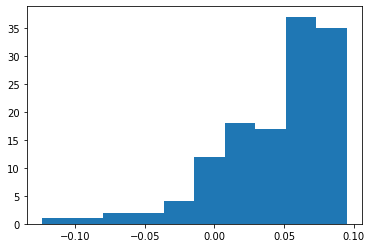

In [218]:
plt.hist(scores_pred_lib)

In [130]:
file = open("save_vectors.ino", "w")

file.write("#include <vector>\n")
file.write("using namespace std;\n\n")
file.write("struct Tree{\n")
file.write("    int child_id_left, child_id_right, feature, n_samples;\n")
file.write("    float threshold;\n")
file.write("};\n\n")

file.write("vector<vector<Tree>> iForest;\n")
m = 0
while m < clf_lib.n_estimators:
    file.write("std::vector<Tree> iTree" + str(m + 1) + ";\n")
    m += 1
file.write("\n")

f = 0
file.write("void setup() {\n")
file.write("    Serial.begin(9600);\n")
while f < clf_lib.n_estimators:
    j = 0
    while j < len(clf_lib.estimators_[f].tree_.feature):
        temp_child_l = clf_lib.estimators_[f].tree_.children_left[j]
        if clf_lib.estimators_[f].tree_.children_left[j] == -1:
            temp_child_l = 0

        temp_child_r = clf_lib.estimators_[f].tree_.children_right[j]
        if temp_child_r == clf_lib.estimators_[f].tree_.children_right[j] == -1:
            temp_child_r = 0

        temp_feature = clf_lib.estimators_[f].tree_.feature[j]
        temp_threshold = clf_lib.estimators_[f].tree_.threshold[j]
        temps_values = clf_lib.estimators_[f].tree_.n_node_samples[j]

        file.write("    iTree" + str(f + 1) + ".push_back({"  
                                                            + str(temp_child_l) + ", "
                                                            + str(temp_child_r) + ", "
                                                            + str(temp_feature) + ", "
                                                            + str(temps_values) + ", "
                                                            + str(temp_threshold) + 
                                                        "});\n")

        j += 1

    file.write("    iForest.push_back(iTree" + str(f + 1) + ");\n\n")
    f += 1

rows = f*j
memory_per_vector = 8
allocated_memory = rows * memory_per_vector
file.write("}\n")
file.write("void loop() {\n")
file.write("\n}")




2

<Figure size 1080x864 with 0 Axes>

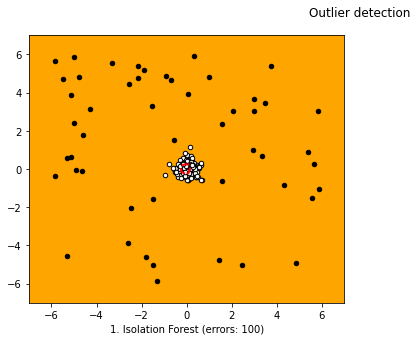

In [155]:
# Fit the models with the generated data and 
# compare model performances
def c(size):
    if size > 2:
        return 2 * (np.log(size-1)+0.5772156649) - 2*(size-1)/size
    if size == 2:
        return 1
    return 0

np.random.seed(42)
clf = antonForest(100, 256, random_state=random_state)
clf_lib = IsolationForest(random_state=random_state)
# Data generation
X1 = 0.3 * np.random.randn(n_inliers // 2, 2) #Removed offest
X2 = 0.3 * np.random.randn(n_inliers // 2, 2) #Removed offset
X = np.r_[X1, X2]
# Add outliers
X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]


# Fit the model
plt.figure(figsize=(15, 12))
# fit the data and tag outliers
clf.fit(X)
clf_lib.fit(X)
#WARNING put +1
scores_pred = clf.decision_function(X) * 1
scores_pred_lib = clf_lib.decision_function(X) * 1 

threshold = percentile(scores_pred, 100 * outliers_fraction)
threshold_lib = percentile(scores_pred_lib, 100 * outliers_fraction)

y_pred = clf.predict(X, threshold) * -1
y_pred = (y_pred + 1) #/ 2

y_pred_lib = clf_lib.predict(X) * -1
y_pred_lib = (y_pred_lib + 1) / 2

n_errors = (y_pred != ground_truth).sum()
# plot the levels lines and the points

#WARNING +1
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * 1
Z = Z.reshape(xx.shape)
plt.figure(figsize=[10,10])
subplot = plt.subplot(2, 2, 1)
subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                    cmap=plt.cm.Blues_r)
a = subplot.contour(xx, yy, Z, levels=[threshold], #Removed - in front of threshold, since -score
                    linewidths=2, colors='red')
subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                    colors='orange')
b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                    s=20, edgecolor='k')
c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                    s=20, edgecolor='k')
subplot.axis('tight')
subplot.set_xlabel("%d. %s (errors: %d)" % (1, "Isolation Forest", n_errors))
subplot.set_xlim((-7, 7))
subplot.set_ylim((-7, 7))
plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
plt.suptitle("Outlier detection")
plt.show()